# Import Data

In [1]:
%cd '/Users/siyu/Downloads'
import pandas as pd
dr_lab=pd.read_csv("dr_lab.csv")

/Users/siyu/Downloads


In [2]:
str(dr_lab.encounter_id)

'0             1445224\n1             1445224\n2             1445087\n3             1445087\n4             1566664\n              ...    \n55256065    368098637\n55256066    368098637\n55256067    368098637\n55256068    368098637\n55256069    368098637\nName: encounter_id, Length: 55256070, dtype: int64'

In [3]:
#no_dr_lab=pd.read_csv("no_dr_lab.csv")
DEncounter=pd.read_csv("DEncounter_reduced.csv",delimiter = "\t")
Diagnosis=pd.read_csv("Diagnosis_reduced1.csv",delimiter = "\t")

In [4]:
DEncounter.columns=DEncounter.columns.str.lower()

# Delete blank records and transform data type of certain columns

In [5]:
DEncounter.isnull().sum()

encounter_id            1
patient_sk              1
race              2466851
gender               6791
age_in_years      1938386
admitted_dt_tm    1828783
dtype: int64

In [6]:
DEncounter.dropna(inplace=True)

In [7]:
DEncounter.encounter_id=DEncounter.encounter_id.astype(int)
DEncounter.patient_sk=DEncounter.patient_sk.astype(int)

In [8]:
Diagnosis.columns=Diagnosis.columns.str.lower()

In [9]:
Diagnosis.dropna(inplace=True)

In [10]:
Diagnosis.encounter_id=Diagnosis.encounter_id.astype(int)
Diagnosis.diagnosis_priority=Diagnosis.diagnosis_priority.astype(int)

# Find all the DR dignosis encounter then locate all the target patients

In [11]:
Diagnosis_target=Diagnosis[Diagnosis.diagnosis_code.isin(["362.0", "362.01", "362.02", "362.03", "362.04", "362.05", "362.06",
                                                         "E11.311", "E11.319", "E11.3211", "E11.3212", "E11.3213", "E11.3219", 
                                                          "E11.3291", "E11.3293", "E11.3299", "E11.3311", "E11.3312", "E11.3313", 
                                                          "E11.3319", "E11.3391", "E11.3392", "E11.3393", "E11.3399", "E11.3411", 
                                                          "E11.3412", "E11.3413", "E11.3419", "E11.3491", "E11.3492", "E11.3493",
                                                          "E11.3499", "E11.3511", "E11.3512", "E11.3513", "E11.3519", "E11.3521", 
                                                          "E11.3522", "E11.3523", "E11.3529", "E11.3531", "E11.3532", 
                                                          "E11.3533", "E11.3539", "E11.3541", "E11.3542", "E11.3543", "E11.3549", 
                                                          "E11.3551", "E11.3552", "E11.3553", "E11.3559", "E11.3591", "E11.3592", 
                                                          "E11.3593", "E11.3599", "E10.311", "E10.319", "E10.3211", "E10.3212", 
                                                          "E10.3213", "E10.3219", "E10.3291", "E10.3293", "E10.3299", "E10.3311", 
                                                          "E10.3312", "E10.3313", "E10.3319", "E10.3392", "E10.3393", "E10.3399", 
                                                          "E10.3411", "E10.3412", "E10.3419", "E10.3491", "E10.3492", "E10.3493", 
                                                          "E10.3499", "E10.3511", "E10.3512", "E10.3513", "E10.3519", "E10.3521", 
                                                          "E10.3522", "E10.3523", "E10.3529", "E10.3531", "E10.3532", "E10.3533", 
                                                          "E10.3539", "E10.3541", "E10.3542", "E10.3543", "E10.3549", "E10.3551", 
                                                          "E10.3552", "E10.3553", "E10.3559", "E10.3591", "E10.3592", "E10.3593", 
                                                          "E10.3599"])]

In [12]:
new=dr_lab.encounter_id.isin(Diagnosis_target.encounter_id.unique())
target_patient_key=dr_lab[new].patient_sk.unique()
patient_new=dr_lab.patient_sk.isin(target_patient_key)
dr_patient_new=dr_lab[patient_new]

## Create a new variable to indicate whether patient is diagnosed as DR during that encounter 

In [13]:
dr_patient_new['dr_encounter']=dr_patient_new.encounter_id.isin(Diagnosis_target.encounter_id.unique())
dr_patient_new.dr_encounter=dr_patient_new.dr_encounter.astype(int)

/var/folders/2n/wy2j47ss1lb443rj3f6dmkzw0000gn/T/ipykernel_33742/3310620989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_patient_new['dr_encounter']=dr_patient_new.encounter_id.isin(Diagnosis_target.encounter_id.unique())
/Users/siyu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Merge dr patient lab results and demographic information

In [14]:
dr_sort=dr_patient_new.sort_values(by='lab_verified_dt_tm')

In [15]:
dr=pd.merge(dr_sort,DEncounter,how="left",on="encounter_id")

In [16]:
dr.drop(columns='patient_sk_y',inplace=True)

In [17]:
dr.rename(columns={"patient_sk_x": "patient_sk"},inplace=True)

# Creatinine data construction

In [18]:
dr_creat=dr[dr["lab_procedure_name"]=='Creatinine, Serum Quantitative']
dr_creat=dr_creat.sort_values(by=['patient_sk','lab_verified_dt_tm']).dropna()
dr_creat_prep=dr_creat.groupby("encounter_id").first().sort_values(by=['patient_sk','lab_verified_dt_tm']).reset_index()
dr_creat_mean=dr_creat.groupby('encounter_id').mean()
dr_creat_final=dr_creat_prep.merge(dr_creat_mean,how='left',on='encounter_id').drop(columns=['numeric_result_x','patient_sk_y','dr_encounter_y','age_in_years_y'])
dr_creat_final.rename(columns={'patient_sk_x':'patient_sk','dr_encounter_x':'dr_encounter','age_in_years_x':'age_in_years','numeric_result_y':'numeric_result'},inplace=True)

## Select all the information before and including the first DR diagnosis encounter

In [19]:
df_creat=pd.DataFrame()
for key in dr_creat_final.patient_sk.unique():
    if ((len(dr_creat_final[dr_creat_final.patient_sk==key].encounter_id.unique())>=3) and (dr_creat_final[dr_creat_final.patient_sk==key].dr_encounter.sum()>0)) :
        en_id=dr_creat_final[(dr_creat_final.patient_sk==key)&(dr_creat_final.dr_encounter==True)].iloc[0]["encounter_id"]
        time=dr_creat_final[dr_creat_final.encounter_id==en_id].lab_verified_dt_tm.max()
        df_patient=dr_creat_final[(dr_creat_final.patient_sk==key)&(dr_creat_final.lab_verified_dt_tm<=time)]
        df_creat=df_creat.append(df_patient,ignore_index=True)

## Find all patients who have at least 4 encounters including the first DR diagnosis encounter and keep the last 4 encounters' informatioin

In [ ]:
countdf =df_creat.groupby('patient_sk').count()
df_creat_final = df_creat.loc[df_creat['patient_sk'].isin(countdf[countdf['encounter_id'] > 3].index)]
df_creat_final=df_creat_final.groupby('patient_sk').tail(4)

## Create a variable indicate the encounter order for each patient and using the mean of numeric result instead of the first measurement in each encounter to reduce measurement errors

In [23]:
df_creat_final['encounter_order']=df_creat_final.groupby('patient_sk').cumcount()+1
df_creat_final=df_creat_final.reset_index()

In [24]:
df_creat_mean=df_creat.groupby('encounter_id',as_index=False).mean()
df_creat_final=df_creat_final.merge(df_creat_mean,how='left',on='encounter_id').drop(columns=['numeric_result_x','patient_sk_y','dr_encounter_y','age_in_years_y'])
df_creat_final.rename(columns={'patient_sk_x':'patient_sk','dr_encounter_x':'dr_encounter','age_in_years_x':'age_in_years','numeric_result_y':'numeric_result'},inplace=True)
df_creat_final['patient_sk']=df_creat_final.patient_sk.astype(str)

## In order to use reverse alignment method, we need to let last encounter as time origin and calculate the time difference from origin.

In [25]:
df_creat_final['lab_verified_dt_tm']=pd.to_datetime(df_creat_final['lab_verified_dt_tm'])
df_creat_final['patient_sk']=df_creat_final.patient_sk.astype(int)
df_creat_final['last_time']=pd.to_datetime(df_creat_final.groupby('patient_sk').lab_verified_dt_tm.max().repeat(4).reset_index().sort_values(by=['patient_sk']).lab_verified_dt_tm)
df_creat_final.drop(columns='index',inplace=True)
df_creat_final['time_diff']=-(df_creat_final['last_time']-df_creat_final['lab_verified_dt_tm']).dt.days
df_creat_final['patient_sk']=df_creat_final.patient_sk.astype(str)

## Draw line plot to see the trend for each patient and a lmplot to observe the overall trend.

<AxesSubplot:xlabel='encounter_order', ylabel='numeric_result'>

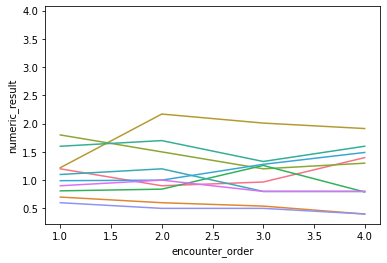

In [26]:
import seaborn as sns
sample_data=df_creat_final.loc[40:80,('patient_sk','numeric_result','encounter_order')]
sns.lineplot(data=sample_data, x="encounter_order", y="numeric_result", hue="patient_sk",legend=False)

<AxesSubplot:xlabel='time_diff', ylabel='numeric_result'>

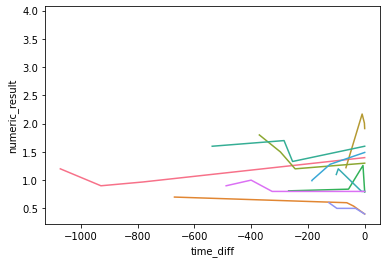

In [27]:
sample_data=df_creat_final.loc[40:80,('patient_sk','numeric_result','time_diff')]
sns.lineplot(data=sample_data, x="time_diff", y="numeric_result", hue="patient_sk",legend=False)

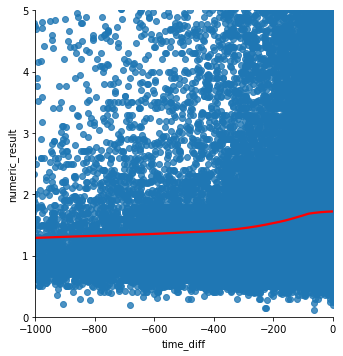

In [28]:
g1=sns.lmplot(data=df_creat_final,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})
g1.set(xlim=(-1000,0),ylim=(0,5))

# HbA1C data

In [29]:
dr_HbA1C=dr[dr.lab_procedure_name=='Hemoglobin A1C (Glycosylated Hemoglobin)'].
dr_HbA1C=dr_HbA1C.dropna()
df_HbA1C=pd.DataFrame()
for key in dr_HbA1C.patient_sk.unique():
    if ((len(dr_HbA1C[dr_HbA1C.patient_sk==key].encounter_id.unique())>=3) and (dr_HbA1C[dr_HbA1C.patient_sk==key].dr_encounter.sum()>0)) :
        en_id=dr_HbA1C[(dr_HbA1C.patient_sk==key)&(dr_HbA1C.dr_encounter==True)].iloc[0]["encounter_id"]
        time=dr_HbA1C[dr_HbA1C.encounter_id==en_id].lab_verified_dt_tm.max()
        df_patient=dr_HbA1C[(dr_HbA1C.patient_sk==key)&(dr_HbA1C.lab_verified_dt_tm<=time)]
        df_HbA1C=df_HbA1C.append(df_patient,ignore_index=True)

In [215]:
df_HbA1C=df_HbA1C[df_HbA1C.unit=='%']
df_HbA1C.unit.unique()

array(['%'], dtype=object)

In [211]:
df_HbA1C_final=df_HbA1C.groupby("encounter_id").first().sort_values(by=['patient_sk','lab_verified_dt_tm']).reset_index()
countdf =df_HbA1C_final.groupby('patient_sk').count()
df_HbA1C_final = df_HbA1C_final.loc[df_HbA1C_final['patient_sk'].isin(countdf[countdf['encounter_id'] > 3].index)]

In [212]:
df_HbA1C_final=df_HbA1C_final.groupby('patient_sk').tail(4)
df_HbA1C_final['encounter_order']=df_HbA1C_final.groupby('patient_sk').cumcount()+1
df_HbA1C_final=df_HbA1C_final.reset_index()
df_HbA1C_final['patient_sk']=df_HbA1C_final.patient_sk.astype(str)

<AxesSubplot:xlabel='encounter_order', ylabel='numeric_result'>

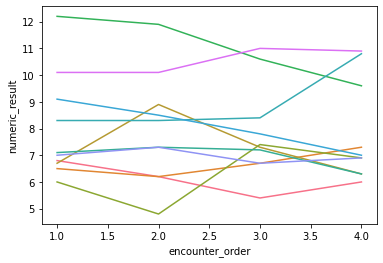

In [213]:
sample_data_1=df_HbA1C_final.loc[40:80,('patient_sk','numeric_result','encounter_order')]
sns.lineplot(data=sample_data_1, x="encounter_order", y="numeric_result", hue="patient_sk",legend=False)

In [214]:
df_HbA1C_final['lab_verified_dt_tm']=pd.to_datetime(df_HbA1C_final['lab_verified_dt_tm'])
df_HbA1C_final['patient_sk']=df_HbA1C_final.patient_sk.astype(int)
df_HbA1C_final['last_time']=pd.to_datetime(df_HbA1C_final.groupby('patient_sk').lab_verified_dt_tm.max().repeat(4).reset_index().sort_values(by=['patient_sk']).lab_verified_dt_tm)
df_HbA1C_final['time_diff']=-(df_HbA1C_final['last_time']-df_HbA1C_final['lab_verified_dt_tm']).dt.days

TypeError: Cannot interpret '{'8206936', '13170806', '39665111', '81964177', '17612993', '39471352', '2230777', '41927304', '10503063', '42679709', '12590452', '16140553', '39416805', '43805182', '40303034', '39103554', '13387064', '34483161', '2231819', '8206682', '42244207', '42177098', '9034287', '2080654', '2681271', '47791377', '84137707', '44603730', '43750016', '57615581', '39112596', '10292955', '30564573', '2230604', '2232274', '11097465', '57627', '2090908', '12788227', '1881665', '2230446', '46650194', '2241278', '43094953', '12901778', '12566437', '13658196', '41735862', '51825', '2229710', '46650377', '10416275', '8269513', '45229197', '11098214', '2284115', '2437792', '15308765', '47332016', '15853124', '44783884', '9381587', '41942222', '2443982', '41628181', '36865758', '42573347', '47930171', '39147470', '43711847', '15928012', '8787027', '39623081', '748383', '9044968', '12588821', '47120187', '1936182', '2282275', '14146478', '12525242', '12658828', '12625395', '43292500', '2090604', '39290137', '17517193', '3759895', '43749893', '2331381', '1830249', '14059506', '35315381', '40231175', '12885388', '816800', '42348825', '32253690', '1946736', '2330890', '10424450', '39225349', '2095249', '7785761', '47843719', '43037393', '52372', '9043259', '360444', '42511227', '12235085', '2182655', '2282300', '11097086', '8276011', '17954228', '2089515', '240227', '2592886', '10825358', '11467838', '17586256', '11306077', '10955536', '34668961', '41560291', '47913732', '12734069', '18039438', '6684171', '13168484', '39149770', '81880731', '12523682', '12697128', '55194', '39102861', '2317834', '9724024', '13680324', '42783332', '443733', '43787223', '8507545', '5482447', '39069241', '42902828', '39103154', '10499310', '46896427', '11233924', '39100475', '9794185', '17549521', '16138291', '14500786', '15255803', '15713122', '2429824', '1863481', '2183767', '35366213', '39148143', '43033529', '39245146', '15852824', '312796', '515033', '255077', '2381403', '38041587', '56719130', '43710825', '14714940', '2228971', '2281033', '15920045', '15712903', '13293440', '41858234', '42398376', '262831', '2181675', '17799362', '42066286', '13956800', '1830603', '8530859', '37024911', '8787543', '708022', '8252013', '47555017', '40154163', '16867631', '17701071', '2181904', '42381412', '46921764', '46931240', '2290150', '39339415', '42904464', '29583451', '43821639', '14575977', '18157295', '43021301', '12788600', '34303569', '2233806', '46441309', '2002788', '5477391', '2395590', '29867937', '34669393', '8272461', '45251445', '81583214', '43710465', '344309', '5643849', '1931788', '13369786', '6592677', '34310449', '43223869', '2434168', '11384413', '13284092', '12889312', '42116317', '12786065', '2384050', '13173764', '17829259', '761032', '46660735', '9985337', '41654624', '2442040', '1794181', '39148795', '47762008', '1894344', '29863171', '8042735', '2329609', '17512222', '39115860', '29889397', '34990134', '38265542', '2431828', '17794780', '17511830', '8357890', '42380783', '11097839', '38655549', '1675306', '46875951', '5173936', '12432171', '13662371', '42842381', '43711730', '41448933', '17944474', '32202993', '2113037', '443836', '42725328', '7865417', '2014784', '39567476', '661396', '12695060', '15782667', '266393', '11165457', '734737', '2337963', '32328799', '5330353', '5484701', '41932074', '43283902', '30617998', '2624554', '46897296', '47540407', '2351923', '29886730', '2091471', '10577463', '13547709', '46881067', '1828186', '16495404', '17613706', '1767264', '2434592', '8712132', '40603', '13386619', '2047618', '43086862', '10925564', '13970040', '9752157', '30396774', '29861346', '41633296', '1878092', '8376719', '2288585', '43729683', '2231219', '43821586', '2331505', '39210366', '253131', '2246606', '13652246', '2397587', '41935050', '47577541', '42561169', '39101982', '81470460', '13184537', '43305144', '15799644', '17892005', '17485581', '30615316', '42892252', '42747670', '45112227', '8271590', '8228155', '650976', '43771849', '10761985', '42572084', '42682469', '8248754', '1932246', '13276073', '15918236', '2280577', '2142564', '11178283', '39768087', '17671956', '17798142', '46668903', '2230742', '2336584', '7172262', '46906301', '12622091', '42506715', '15441003', '11233776', '30076668', '8889772', '39223898', '43827673', '3686025', '9121024', '18253424', '360543', '8207306', '29862101', '6829371', '768250', '47122642', '9791780', '591288', '43785985', '2001444', '30628621', '12616214', '41662294', '35302782', '52700', '47318757', '9924407', '31608973', '32311952', '15785101', '34663481', '43822677', '30485596', '37078703', '8694386', '8187895', '46467245', '452796', '2230449', '703025', '1752606', '43727927', '369166', '13747770', '2233691', '8249828', '47564509', '2430939', '290705', '9722539', '8248680', '11309628', '8126027', '4309091', '16947040', '39245433', '17799200', '5406659', '57900', '34753138', '2382784', '39810536', '16135335', '41943130', '708417', '47533788', '43766361', '9872596', '45032661', '2330787', '16125266', '2225591', '12532066', '13947754', '42797430', '42973879', '5747085', '8329497', '30877827', '46731302', '47265624', '7263195', '43953150', '8256210', '43152912', '47849447', '2279624', '14162615', '42335910', '2322804', '48144632', '44912472', '39161332', '2380536', '8314252', '456329', '314952', '32081188', '47393071', '2621029', '43745725', '2338028', '2231089', '8041290', '11461530', '30175435', '43930229', '39151948', '81639992', '2437144', '43096365', '17608409', '851263', '29876789', '2101143', '12989136', '764253', '34483501', '8270672', '1995957', '42732355', '246693', '1735064', '34393669', '520093', '9720454', '42197091', '2283934', '2263105', '2096356', '762257', '30177149', '41543328', '12475085', '2382681', '39100282', '43527798', '2356385', '29889741', '9855832', '10428095', '13100027', '2439326', '8687112', '8296136', '17508072', '241665', '2184882', '2256941', '16882350', '37649096', '17480586', '39066122', '42888729', '46662943', '15780373', '39700526', '47573562', '39426892', '5717526', '41733439', '2093517', '5233406', '12741206', '10410782', '39075516', '12886050', '9398798', '13176668', '43269601', '39195912', '44002038', '15713652', '11529913', '8451515', '13376439', '8712537', '34576182', '29728779', '42732224', '12435926', '30330711', '12890927', '14143166', '8338558', '7164829', '15713217', '242469', '81640689', '11602103', '29782865', '12691544', '42726951', '39337651', '6981012', '39444403', '43779708', '39419575', '43999821', '314396', '41532710', '10940388', '41634227', '9783059', '8273272', '14999885', '9035147', '2183824', '30166998', '368245', '41945373', '30839956', '1985474', '2186528', '48013659', '32128867', '35087067', '14170122', '17511346', '2589692', '30009459', '39263921', '332329', '1881482', '47142826', '30599801', '2022648', '10752762', '2092348', '450132', '11109182', '47779962', '2193500', '41486838', '46711604', '1888553', '10425051', '17707586', '41628331', '15192517', '7023583', '41940822', '1776261', '2090513', '2287786', '11165542', '17944101', '13072279', '40313355', '15249355', '47839987', '254290', '41550622', '39415414', '11218397', '30322411', '9403786', '13274143', '15712355', '15853332', '12877960', '34393227', '15398999', '2330928', '11444653', '81965555', '39670055', '1922714', '11234316', '31637199', '13569512', '2283079', '8347112', '41888559', '8175117', '8827701', '39154228', '2288065', '40184', '43220409', '34755597', '39092170', '5558263', '39229382', '7168808', '9410099', '43864915', '40289404', '2205507', '17523942', '6981993', '2232221', '2182582', '12570516', '2398161', '11379315', '17763297', '10066603', '43727838', '47802882', '2173611', '3594390', '12738045', '2096440', '3735916', '5244621', '7217564', '7262182', '51419', '16068796', '43304878', '52610', '43744881', '17877422', '30154260', '41874341', '43044205', '2331282', '2432893', '16605312', '43790914', '12993572', '41825989', '15710863', '2089321', '14577334', '8309967', '42630400', '12571450', '17883526', '1682747', '12481708', '12799222', '10526147', '2620818', '44942191', '57888', '2385609', '15725562', '15778472', '37341056', '2179046', '45280110', '47386832', '2091029', '2331123', '37344631', '41628405', '43734909', '13852657', '47783824', '11443454', '81722576', '1787764', '1882868', '2241969', '15734437', '1891861', '9035630', '43026891', '42977058', '47102541', '54247', '16557682', '43156953', '8590727', '39337695', '15069560', '44707527', '47588294', '2095753', '14476213', '12584991', '2284685', '44698741', '2181254', '1950440', '9375654', '44693235', '46872776', '12222933', '81691047', '47117815', '1935513', '15299043', '1724301', '10171481', '851095', '42044870', '9037721', '13543014', '7927500', '453390', '10099936', '54318', '39242063', '8470970', '41740463', '461215', '1878351', '2332469', '9034036', '48091226', '47764289', '46662354', '9843270', '2181517', '2093693', '14278061', '2184780', '7271269', '5581326', '39340624', '47541446', '47767865', '7073507', '30028329', '1723832', '2388548', '1773103', '70543', '44855527', '2140236', '43831806', '81590950', '36411120', '2333817', '12978699', '81531812', '39291304', '2197202', '41843122', '266847', '362634', '2382473', '42184461', '53248135', '41737951', '7144516', '662142', '39238864', '8415172', '11460397', '2436786', '42894202', '13285496', '490700', '43086934', '246423', '2435608', '2012693', '1809143', '44909347', '11105933', '16057323', '16931660', '1679322', '41657099', '2432239', '47817444', '42466332', '1876693', '15927888', '43711140', '47433515', '81689107', '17803629', '17944064', '58300', '5400937', '9768891', '37964950', '1938565', '2265915', '9763483', '41825360', '1881524', '29769832', '11098596', '852918', '47765063', '8210703', '42573100', '43235763', '58086', '10564987', '11171994', '8263085', '11184243', '1768945', '12695080', '35090349', '40629', '10158325', '35530874', '44827648', '2680771', '39409471', '9468866', '2283966', '13383335', '39291139', '17740817', '5748677', '2285560', '14614026', '39108067', '44799986', '13021331', '5654958', '12567950', '46889119', '2279364', '2095998', '47319721', '11208598', '15987254', '42898561', '47097117', '2434982', '8362981', '39246348', '8826734', '44076535', '43729936', '1778905', '16893773', '768517', '46442867', '235336', '47182426', '81729740', '9075477', '2429768', '65566948', '8550005', '9059623', '41485105', '34304241', '41596592', '42966996', '15217103', '322822', '2283322', '12747435', '81920037', '43710099', '1883383', '46873255', '30696647', '5652110', '2089879', '7217539', '42843882', '521162', '8210575', '2398162', '8207165', '39665795', '39014052', '42564319', '9032566', '9508374', '2090876', '43807134', '9065608', '9055646', '16512293', '57114', '12620202', '41752505', '30641090', '34488478', '15995075', '2280160', '58268816', '17747723', '47095508', '8228915', '31017226', '17670335', '46908076', '43340554', '11170670', '12881644', '34845470', '311923', '44948708', '12883308', '3605909', '16011640', '43157900', '34488246', '2329067', '17544109', '77465820', '44005933', '13975380', '62875385', '16434887', '47377014', '2793051', '8237336', '42746767', '43731349', '2117588', '2331442', '2596135', '30010311', '16151520', '2331764', '61308774', '12616196', '46883191', '8305560', '81588615', '44783843', '5868969', '42977378', '30764935', '38922525', '42463550', '9724220', '43167008', '12884812', '36406289', '43747751', '47768249', '11166533', '42514071', '42785929', '56207', '42322852', '9059107', '1985377', '8230741', '17584471', '48155464', '36405523', '43152328', '2230617', '7025239', '30046964', '2282346', '44039447', '41532775', '39151574', '39593403', '630929', '46884727', '31112341', '43820060', '313767', '43898296', '1949323', '17762162', '41925515', '46487434', '9429452', '14589906', '30179185', '2330149', '43167849', '2433127', '45065542', '17939868', '18075143', '43157104', '35305388', '9043098', '42169555', '41628492', '17838791', '1682379', '8236051', '2229235', '17668284', '12434318', '16938035', '41743149', '47764758', '47773199', '30319812', '1799794', '47114893', '39301851', '8687898', '3711050', '56707179', '2435207', '47337144', '17973438', '13094983', '14509616', '1866965', '9035194', '11181836', '34576964', '2284515', '2234462', '2359687', '29877620', '8009610', '305472', '17767100', '46663544', '11103387', '1777800', '8103138', '577146', '2329988', '13288237', '47552171', '2016909', '244118', '2065502', '43731472', '11099871', '12744189', '1696998', '42890656', '11392029', '15802950', '39967364', '2436181', '2330058', '16094106', '2386282', '44815849', '9375799', '47617889', '8270458', '11442029', '2444945', '46517735', '1990163', '11450058', '2184669', '10086873', '12445256', '1988058', '47551145', '39242123', '35201948', '14332367', '12899766', '30200539', '768375', '16007954', '16128560', '2231741', '13172498', '12888268', '41626733', '17677778', '17543951', '37960661', '43803094', '2197284', '8346729', '7068162', '17607634', '2433825', '30384211', '29734591', '31855906', '15725949', '8292937', '2591646', '48026995', '810853', '81623114', '2182001', '12662756', '6971205', '47830069', '12543578', '41640758', '7163959', '34303867', '741624', '13371108', '42459739', '2233766', '17877953', '34305164', '12878048', '15167644', '2333201', '12736149', '13274948', '13095227', '8303393', '11460480', '2423474', '13275739', '42453148', '1930255', '8309624', '5397881', '9735732', '15847862', '52331', '12894858', '17547722', '5409873', '2380430', '7967657', '39798737', '39339928', '41653892', '43776236', '2005289', '39337850', '48068337', '7265014', '15862178', '35048577', '46878632', '17548675', '6720270', '48025483', '8893501', '37338883', '47335645', '37031275', '15719486', '44660294', '12978153', '13364172', '17799985', '47454939', '8721921', '46444954', '7145307', '46896198', '11100838', '1829958', '47097478', '9032116', '39404890', '2280823', '2298335', '234828', '2380818', '31906261', '54381119', '2430255', '13378616', '300157', '8686941', '2480185', '8228947', '11376289', '43159290', '5154744', '16060184', '41625551', '43746824', '39148150', '313584', '44859823', '1793767', '41628036', '9125692', '30457384', '2355642', '18111720', '46880263', '732809', '17479190', '12985081', '41836882', '15860104', '2284062', '10758135', '239867', '9938251', '43715946', '47317455', '18191258', '2452372', '55709', '302455', '53161599', '31138599', '41728030', '8206807', '40226907', '41824555', '43803856', '12481277', '8229391', '259575', '9053057', '762963', '6981433', '13080737', '1811955', '15192069', '17974501', '81617067', '2285561', '2092535', '14824862', '41681698', '41569678', '31216105', '2291638', '8348773', '651550', '17768483', '29510237', '850310', '17520219', '42072857', '8320209', '7016568', '41824609', '1720672', '15989634', '8209370', '35142174', '10759279', '13272668', '53885335', '14609538', '2382788', '41727041', '39201712', '43828708', '1775457', '858323', '43827288', '42508811', '56813', '12476636', '2237610', '64264625', '47775209', '760771', '7017781', '15789235', '12690969', '2382508', '1720971', '13875905', '14057917', '17571330', '8877567', '9031752', '1878658', '1718072', '2184595', '12581595', '15497338', '1875902', '2016153', '2388152', '855209', '44792447', '45162521', '14343552', '46882302', '37341653', '39419982', '42594763', '12991778', '12527373', '15711259', '37999684', '2333309', '13853577', '5321648', '2379815', '15229103', '15855983', '43709581', '11311444', '39765819', '47570439', '32153214', '470478', '7164753', '17486859', '43745013', '43767097', '30596307', '2382418', '2228850', '1728101', '43097427', '38590153', '42175612', '17878022', '8365196', '2713692', '30035862', '10216269', '47242028', '1963877', '10776949', '2106284', '14829360', '37038496', '47206626', '855058', '15919252', '48090297', '11480484', '17877378', '39348508', '2184773', '42917122', '47638221', '42979994', '13375419', '534089', '12973849', '39762424', '43745680', '2281049', '35459649', '42960828', '8211209', '17731424', '46438176', '2233757', '1883948', '17794398', '42891901', '42837021', '48082193', '11240397', '18264622', '35176457', '8708683', '17697772', '30176621', '47096369', '17542391', '13558433', '42860758', '41843068', '1933614', '81790258', '13177362', '43159692', '42562322', '47197849', '1677503', '5722293', '11170022', '7311396', '45282091', '2239278', '191511', '448922', '2399415', '10761205', '255727', '13076158', '13371669', '42736904', '48189699', '41643345', '10965956', '10412137', '10884634', '44597534', '46450477', '30011183', '12741762', '44851363', '2763742', '11508509', '47556906', '11026295', '2436470', '11528589', '8228753', '43770330', '47325210', '39216673', '15993076', '17523552', '41552542', '41972239', '46890392', '2432282', '43237192', '14620727', '14750983', '17509738', '56577773', '56785256', '313125', '48050464', '8335337', '9034393', '301126', '48099684', '8244223', '47542120', '47503299', '6901276', '13182567', '9035843', '46706182', '30328659', '43702598', '38894329', '15157255', '43104391', '47556096', '857304', '47101852', '2380699', '9203453', '12779383', '2242933', '11307641', '13380060', '15926587', '191971', '47104730', '2432220', '17826564', '37650027', '8311726', '30169942', '39070687', '43714882', '8121554', '13173517', '36717194', '310966', '43849', '13552668', '1687817', '1789045', '1855565', '17497910', '55827', '48088838', '12457066', '43166273', '6931317', '11546317', '12435338', '8206980', '12445872', '17507935', '9045705', '5498591', '35606419', '43770388', '6984013', '1941607', '53396', '43788615', '12910429', '30621264', '262357', '5331364', '13091954', '39342816', '2712324', '17912892', '44704582', '37033250', '30156093', '43092107', '81669185', '9377799', '13375575', '39289845', '39767214', '42396447', '14853739', '42785684', '39153138', '42686714', '755624', '16134323', '12799500', '43783318', '56592131', '5315999', '47697264', '81465093', '1883424', '244916', '2017491', '8407113', '81792824', '2329545', '18114801', '43020356', '300349', '42509993', '14340483', '17706210', '8333013', '257967', '17478147', '14844803', '35034129', '46888745', '2171097', '2180013', '11415580', '16125808', '17912461', '47581182', '15786567', '35197640', '41923987', '13848520', '40019065', '1901523', '5886694', '5415822', '43806387', '47498424', '10759842', '2462362', '1941572', '12889808', '12890081', '84691264', '2040456', '11550308', '2381976', '16136370', '42160746', '46693705', '37708724', '41648602', '2285479', '232250', '1896456', '2332652', '2329420', '30599550', '30874081', '30963290', '2230472', '11374959', '2091093', '11378681', '43823706', '34846653', '2329808', '9178076', '17610428', '11305487', '30015829', '30308586', '43152974', '8695112', '47153916', '44819854', '35452554', '81981005', '2231343', '366920', '17795111', '2088891', '241320', '2280658', '65762420', '42961516', '46882974', '300607', '81558811', '1718626', '43035292', '10524651', '52511', '9391457', '81553269', '11396081', '17834104', '56689305', '42032894', '43293341', '43745786', '9032754', '1888074', '2401213', '8698627', '2184099', '42042629', '17577561', '46899012', '42726268', '12875310', '43804449', '7925699', '12498364', '43709219', '8212515', '2187294', '13168629', '13567445', '48077316', '17793693', '35564284', '43823627', '2384180', '10753797', '30459926', '9721279', '43757', '15361575', '17650146', '42477482', '12502844', '43821965', '8234699', '18421481', '12738084', '12755845', '31237423', '8333777', '14332004', '2234108', '15060302', '2329504', '17576360', '18009750', '39775678', '43731466', '2435240', '1985396', '46457873', '18191587', '17480300', '35531207', '44670116', '5594906', '521845', '17578744', '1990864', '30765031', '46444953', '14480934', '43729740', '2231000', '40111679', '41800530', '56990204', '5199298', '53062574', '46463211', '39114492', '17740226', '45114980', '17831337', '2650639', '2384150', '442938', '764925', '10273432', '12826267', '1898249', '15935362', '30012878', '12440752', '81500213', '1878370', '39100512', '46710705', '8249579', '32279254', '2473658', '35673590', '1898684', '11127620', '12980038', '43719334', '31263075', '2139531', '194042', '2229825', '46665386', '54531527', '14349015', '5825773', '8689247', '31338331', '39402365', '2237032', '8867046', '41936128', '43769187', '43828087', '240346', '7936577', '47998283', '57666182', '9544091', '7160533', '37336066', '47507599', '81981377', '12528348', '2144015', '41976467', '2335143', '853719', '39337464', '43734162', '46691971', '13075095', '58260604', '17714874', '81607833', '13375751', '35527120', '651011', '46897771', '13080059', '47406674', '34849919', '66904836', '837972', '42599563', '15469103', '41630429', '39519857', '2089606', '40039328', '11236684', '43163524', '15145641', '37984688', '43170279', '2193036', '18489867', '242025', '5152091', '760164', '13270834', '39617260', '17541614', '16483193', '2103726', '6522360', '11518803', '2431903', '39471819', '39567332', '46951926', '81600501', '29728848', '9397297', '1774727', '47437313', '32327608', '11510868', '1774120', '14701217', '9805168', '14333156', '8269541', '44633430', '2197912', '11190628', '11240896', '44600093', '1828466', '449397', '16060929', '39062589', '11520232', '15303962', '44722800', '39100382', '2285210', '851090', '2431706', '1935376', '11237778', '8323624', '36729551', '16559215', '3687512', '15152892', '2787221', '39482085', '2180307', '2443155', '652738', '46521966', '39418123', '39290633', '2300647', '8709679', '46452113', '12983897', '11240894', '1845716', '47102368', '66117121', '638144', '12523548', '13373722', '2331792', '42453536', '4129226', '1824650', '5676853', '17908226', '34987646', '13087552', '650824', '8249589', '17669920', '10075535', '39432589', '46894716', '8688701', '8367267', '8119602', '9848899', '11443641', '8314774', '46656639', '2323983', '45246515', '10070459', '1826740', '44310', '9397157', '42411081', '37364788', '46872744', '2002593', '39712778', '313420', '2089096', '17579425', '31239839', '11381654', '642453', '2066707', '6612224', '245037', '13277290', '12881714', '55896705', '47375509', '54540764', '15918983', '15784211', '2149526', '9721804', '11170955', '81779535', '17950587', '8406999', '9543756', '251898', '2333962', '7271116', '2443766', '17677277', '36755875', '2100881', '1841114', '35271222', '43773102', '2437042', '41635026', '36403687', '1881514', '31162328', '2194812', '8292927', '2380912', '1957597', '2412524', '17953218', '43768566', '13177258', '763788', '8321951', '40155911', '2043152', '47989476', '43716986', '12436100', '43728913', '45294085', '15111417', '41994693', '47334117', '2076888', '42560062', '17836423', '8325973', '34936944', '43767171', '12199048', '41688947', '660959', '13147169', '2387073', '37350592', '48014445', '46689667', '652158', '43709402', '16433864', '13367389', '42983191', '2379605', '2383885', '9494422', '2285076', '8437132', '8702415', '1959802', '30876276', '12999680', '5806703', '11516029', '48017268', '39470706', '30916447', '10068443', '1894543', '2179701', '39762773', '42139031', '42783536', '46926071', '30811957', '11529571', '9466714', '490191', '670474', '657321', '11171596', '38967957', '17545211', '262194', '39830146', '5482772', '2182433', '334416', '2381584', '41533627', '46666283', '1898242', '31440351', '317482', '16135607', '10435812', '13174944', '1960634', '47129405', '39102324', '47139556', '2301765', '11246464', '53240003', '39567553', '39300271', '12734248', '44881283', '13169486', '39343274', '733573', '11467771', '29735985', '191496', '1924067', '2094764', '17670805', '18103478', '7982071', '41729441', '41943947', '5640860', '15718431', '47318235', '2101374', '11377349', '650843', '1722410', '2281589', '47813393', '47442216', '1895613', '2338233', '43229010', '17542947', '58183', '52605', '45136346', '12881764', '44032288', '1691427', '13366265', '8272556', '45003412', '43025574', '43766256', '35709659', '12524233', '12781095', '2231513', '263414', '47863726', '7965640', '10212668', '10066814', '10434701', '17671048', '12837372', '48144329', '43168828', '35291196', '43767144', '10775236', '41640316', '12796736', '47713406', '45307668', '8293219', '42627919', '2384793', '42165468', '1728762', '8269731', '37034837', '16897815', '9806587', '12908189', '702488', '43227784', '705107', '2043405', '2386728', '39100339', '9798126', '39100180', '42625140', '12783788', '335283', '9817532', '14618892', '8235153', '11584236', '47618486', '42396901', '17820611', '47494507', '10085639', '16022967', '43760072', '2333221', '8228949', '39407201', '36754161', '43225405', '8690255', '17837618', '7606464', '47402506', '1977498', '34848278', '2284580', '10756818', '11236083', '81827599', '16893797', '9768245', '32179228', '8406116', '13082843', '15802834', '30193935', '44910555', '47542996', '17545311', '8309354', '12661224', '9040622', '43710644', '4420926', '8197629', '68534317', '39156279', '15928447', '12399904', '857136', '12883959', '44602162', '46463456', '456102', '46672602', '2294437', '6836398', '13944613', '10072155', '10072612', '39800558', '37972027', '12798261', '2181182', '2382298', '42928898', '2179177', '43764815', '42778775', '254723', '35366019', '39394626', '10074547', '39349931', '47438177', '13368273', '47445692', '53924664', '12533479', '17733642', '9721479', '8298309', '13536601', '2429566', '12434862', '37654991', '38271371', '16061809', '46650122', '39134675', '11182917', '56661691', '850748', '10086259', '39242364', '43290439', '11452154', '40767', '853623', '8690331', '17827865', '267852', '43159397', '43788065', '18396660', '14591523', '16129808', '42745414', '2433577', '10254030', '39148026', '2242223', '44850224', '47145752', '17797820', '11513087', '8227803', '2078855', '1932524', '31887918', '53972775', '145200', '2088966', '7163394', '2336126', '311150', '43025542', '11236312', '12816911', '17773262', '44907335', '9224571', '2279890', '45108244', '12615809', '39230840', '39148281', '10769275', '2330673', '40020656', '46539780', '1683683', '1887649', '12433315', '313165', '42960188', '47581366', '13075376', '13081117', '44597506', '442971', '68471010', '13671442', '2232012', '14455997', '10414075', '13194336', '12738735', '11305164', '10455935', '2283747', '2231244', '47768671', '42505838', '2430776', '10105612', '41932382', '42517092', '47371106', '39616965', '5046050', '8692078', '42955926', '2429946', '43038549', '30016375', '43820116', '5866642', '47189933', '81553055', '39149038', '2230696', '43822392', '41831257', '42919588', '39148720', '2330528', '15987824', '18075757', '39417265', '51756', '1681383', '17512664', '17811400', '39289970', '247737', '52843', '15716314', '11166200', '10411569', '18717404', '10424007', '9913282', '39251884', '47325326', '42572168', '42027632', '1858324', '11170027', '43732835', '43087909', '2230629', '11581274', '34664036', '7066555', '36409225', '46653143', '30317279', '11306601', '42466766', '11470872', '1937466', '12481715', '29862948', '43787732', '43107956', '17698404', '522862', '12520804', '38941369', '16072849', '39339868', '2242090', '2413255', '1988743', '9395427', '13372016', '38268924', '47800516', '251044', '34305282', '42892605', '2331405', '41628088', '39338059', '30303276', '34574866', '11511520', '12163829', '9221051', '43038921', '47539561', '42850521', '44070857', '2090910', '651856', '46663827', '16069635', '312923', '2183862', '39256261', '14454519', '9768842', '42411428', '38572721', '34987633', '40260517', '42365451', '44753946', '43220149', '47792016', '2431418', '17761305', '525148', '1999492', '7139881', '16946396', '41458379', '44967926', '8318432', '17559152', '195983', '1931255', '15116656', '10069549', '18196231', '17482048', '11309011', '12733423', '42720346', '1877004', '41931055', '45081311', '13669242', '42511414', '42395270', '1879283', '12926440', '10579118', '41673749', '1881080', '8207389', '11237072', '45280066', '262366', '48118917', '360182', '42460492', '11238275', '2236758', '45033609', '2279361', '45280676', '37047561', '17879008', '15160609', '34304600', '2091214', '41544867', '634603', '1826554', '1934364', '9043883', '2094863', '1831351', '39246381', '362280', '11104720', '37978696', '2448187', '197147', '48031633', '12796980', '262420', '2333062', '47332124', '81480787', '2381932', '35504143', '45309037', '39200792', '42139617', '58275712', '39206853', '42022488', '8394277', '2230336', '10483480', '12576067', '47426911', '2286567', '10104390', '16004072', '35195467', '44915143', '48006304', '38301833', '2381019', '46673295', '30338265', '10414683', '42148962', '46666163', '15780773', '53092847', '10408541', '8878897', '47338614', '32354741', '10419991', '5590906', '39617441', '12613592', '13372806', '47471558', '8002667', '39611975', '8364127', '17699347', '11111151', '17616817', '2235026', '7263996', '2281563', '31953881', '11101493', '1827349', '13374515', '17588368', '34851621', '47839498', '8269254', '17607669', '1734621', '41676093', '42725137', '9219840', '43654721', '47369022', '2185050', '311037', '42744957', '42844548', '56215', '6682920', '13283262', '1747500', '8010037', '17545425', '16077477', '37970216', '13558500', '9387400', '81690697', '8306727', '7172278', '42451779', '599182', '12983667', '43824307', '11172088', '2064742', '17909693', '2434192', '12796159', '7896589', '35195965', '81635788', '8080375', '12434387', '46764752', '2229668', '2088935', '12571215', '2282853', '44579554', '69816095', '12377083', '39100823', '52251', '2339220', '45268715', '15919192', '17542493', '2621357', '50381', '16135737', '453754', '15306635', '3394837', '12710667', '30164755', '43222023', '12894403', '1964995', '2430251', '29909863', '43739015', '41825826', '10426889', '16067181', '17710750', '2286841', '47779640', '14998548', '2049638', '7169935', '7265439', '12794787', '1895283', '8251106', '2285992', '13516586', '16557576', '13273554', '17920688', '13103738', '8274203', '12624194', '12568873', '14334284', '41728799', '8342523', '42636020', '43787036', '2153480', '3711245', '6591054', '41532069', '2184709', '48056902', '47272486', '17944107', '16770236', '2230603', '8204471', '2280819', '46894067', '10466960', '14831159', '36062656', '41742574', '45310008', '15727725', '45174645', '39212637', '42130033', '2436308', '1955884', '30635137', '12793927', '39665925', '43624068', '763694', '2181331', '2230010', '31832967', '35402277', '81606505', '47613107', '81946560', '764268', '2430646', '47542720', '2440487', '39290798', '2381348', '1932019', '2626193', '43803073', '1935534', '30310098', '12567702', '41550979', '29861612', '12975143', '40169515', '6570734', '12903751', '42792181', '2283544', '11110700', '7155235', '41548076', '52419', '10429646', '46465103', '10590090', '14346516', '1882960', '44979770', '43766961', '4303531', '10767448', '17955746', '653905', '2094964', '2381829', '5334807', '13301713', '29879831', '11005190', '39148426', '42678921', '47767862', '2305935', '47895248', '47226616', '443426', '34424374', '35658350', '8249885', '39063610', '39248971', '2430347', '39720088', '30912700', '11457203', '11382430', '664557', '8210790', '55894291', '1926242', '11165450', '34753404', '43813750', '43826915', '52438', '43539338', '17588685', '30618415', '34394565', '1878040', '11234597', '17524413', '591919', '43802331', '2431457', '39878882', '46654910', '43745733', '35039034', '41823098', '1901185', '2182849', '2386673', '242640', '2276944', '9930387', '13288751', '2182493', '15712869', '2003397', '8175378', '9743149', '39692687', '81756513', '9049463', '2231105', '17701030', '2103513', '2341784', '2452575', '14452965', '9032670', '8365714', '857287', '14463795', '17878507', '39243651', '18379734', '1770348', '2231155', '12521629', '41744244', '46653481', '42376210', '46669376', '46728928', '44999970', '44598972', '2329954', '15926213', '17915733', '11515575', '17671357', '17975782', '13965973', '41784655', '1830110', '38919743', '39132155', '42977851', '764442', '29724053', '81774303', '39147620', '702032', '13387100', '260748', '34309819', '39471012', '9394764', '43730839', '43732191', '1777081', '2000277', '53192', '43750632', '17477758'}' as a data type

In [39]:
df_HbA1C_mean=df_HbA1C.groupby('encounter_id',as_index=False).mean()
df_HbA1C_final=df_HbA1C_final.merge(df_HbA1C_mean,how='left',on='encounter_id').drop(columns=['numeric_result_x','patient_sk_y','dr_encounter_y','age_in_years_y'])
df_HbA1C_final.rename(columns={'patient_sk_x':'patient_sk','dr_encounter_x':'dr_encounter','age_in_years_x':'age_in_years','numeric_result_y':'numeric_result'},inplace=True)

<AxesSubplot:xlabel='time_diff', ylabel='numeric_result'>

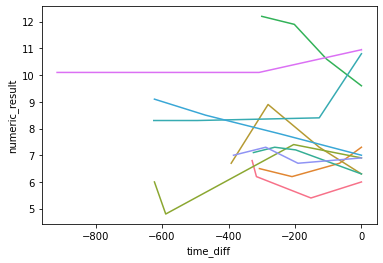

In [40]:
sample_data_1=df_HbA1C_final.loc[40:80,('patient_sk','numeric_result','time_diff')]
sns.lineplot(data=sample_data_1, x="time_diff", y="numeric_result", hue="patient_sk",legend=False)

<AxesSubplot:xlabel='time_diff', ylabel='numeric_result'>

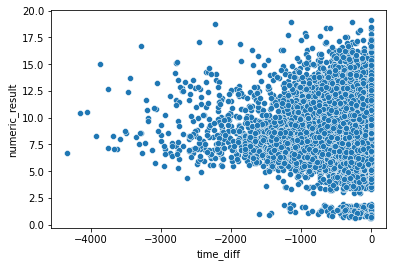

In [42]:
sns.scatterplot(data=df_HbA1C_final,x="time_diff", y="numeric_result")

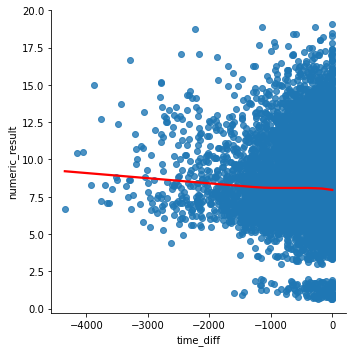

In [43]:
g2=sns.lmplot(data=df_HbA1C_final,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})
g2

# White Blood Cell Count

In [44]:
dr_wbc=dr[dr["lab_procedure_name"]=='White Blood Cell Count'].dropna()

In [45]:
df_wbc=pd.DataFrame()
for key in dr_wbc.patient_sk.unique():
    if ((len(dr_wbc[dr_wbc.patient_sk==key].encounter_id.unique())>=3) and (dr_wbc[dr_wbc.patient_sk==key].dr_encounter.sum()>0)) :
        en_id=dr_wbc[(dr_wbc.patient_sk==key)&(dr_wbc.dr_encounter==True)].iloc[0]["encounter_id"]
        time=dr_wbc[dr_wbc.encounter_id==en_id].lab_verified_dt_tm.max()
        df_patient=dr_wbc[(dr_wbc.patient_sk==key)&(dr_wbc.lab_verified_dt_tm<=time)]
        df_wbc=df_wbc.append(df_patient,ignore_index=True)

In [46]:
df_wbc_mean=df_wbc.groupby('encounter_id',as_index=False).mean()

In [47]:
df_wbc_final=df_wbc.groupby("encounter_id").first().sort_values(by=['patient_sk','lab_verified_dt_tm']).reset_index()
countdf =df_wbc_final.groupby('patient_sk').count()
df_wbc_final = df_wbc_final.loc[df_wbc_final['patient_sk'].isin(countdf[countdf['encounter_id'] > 3].index)]

In [48]:
df_wbc_final=df_wbc_final.groupby('patient_sk').tail(4)
df_wbc_final['encounter_order']=df_wbc_final.groupby('patient_sk').cumcount()+1
df_wbc_final=df_wbc_final.reset_index()
df_wbc_final['patient_sk']=df_wbc_final.patient_sk.astype(str)

In [49]:
df_wbc_final=df_wbc_final.merge(df_wbc_mean,how='left',on='encounter_id').drop(columns=['index','numeric_result_x','patient_sk_y','dr_encounter_y','age_in_years_y'])

In [50]:
df_wbc_final.rename(columns={'patient_sk_x':'patient_sk','dr_encounter_x':'dr_encounter','age_in_years_x':'age_in_years','numeric_result_y':'numeric_result'},inplace=True)

In [51]:
df_wbc_final['lab_verified_dt_tm']=pd.to_datetime(df_wbc_final['lab_verified_dt_tm'])
df_wbc_final['patient_sk']=df_wbc_final.patient_sk.astype(int)
df_wbc_final['last_time']=pd.to_datetime(df_wbc_final.groupby('patient_sk').lab_verified_dt_tm.max().repeat(4).reset_index().sort_values(by=['patient_sk']).lab_verified_dt_tm)
df_wbc_final['time_diff']=-(df_wbc_final['last_time']-df_wbc_final['lab_verified_dt_tm']).dt.days
df_wbc_final['patient_sk']=df_wbc_final.patient_sk.astype(str)

<AxesSubplot:xlabel='time_diff', ylabel='numeric_result'>

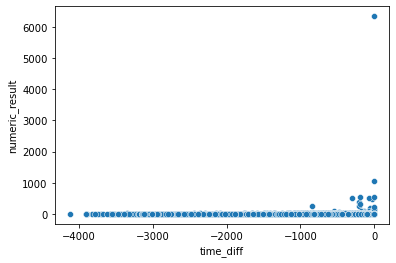

In [52]:
sns.scatterplot(data=df_wbc_final,x="time_diff", y="numeric_result")

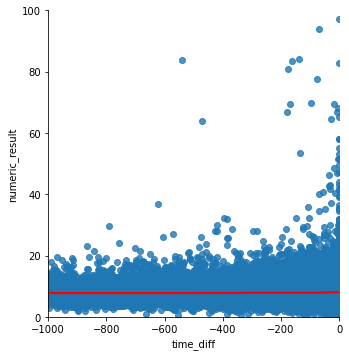

In [207]:
g2=sns.lmplot(data=df_wbc_final,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})
g2.set(ylim=(0,100),xlim=(-1000,0))

<AxesSubplot:xlabel='time_diff', ylabel='numeric_result'>

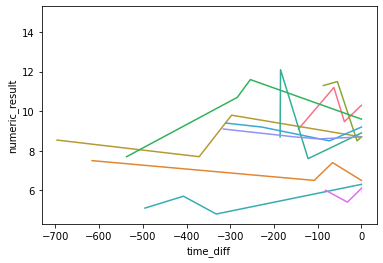

In [198]:
sample_data_3=df_wbc_final.loc[40:80,('patient_sk','numeric_result','time_diff')]
sns.lineplot(data=sample_data_3, x="time_diff", y="numeric_result", hue="patient_sk",legend=False)

# Glucose

In [137]:
dr_glucose=dr[dr['lab_procedure_name']=='Glucose, Serum/Plasma Quantitative'].sort_values(by=['patient_sk','lab_verified_dt_tm']).dropna()
df_glucose=pd.DataFrame()
for key in dr_glucose.patient_sk.unique():
    if ((len(dr_glucose[dr_glucose.patient_sk==key].encounter_id.unique())>=3) and (dr_glucose[dr_glucose.patient_sk==key].dr_encounter.sum()>0)) :
        en_id=dr_glucose[(dr_glucose.patient_sk==key)&(dr_glucose.dr_encounter==True)].iloc[0]["encounter_id"]
        time=dr_glucose[dr_glucose.encounter_id==en_id].lab_verified_dt_tm.max()
        df_patient=dr_glucose[(dr_glucose.patient_sk==key)&(dr_glucose.lab_verified_dt_tm<=time)]
        df_glucose=df_glucose.append(df_patient,ignore_index=True)

In [167]:
df_glucose_final=pd.DataFrame()

In [168]:
df_glucose_final=df_glucose.groupby("encounter_id").first().sort_values(by=['patient_sk','lab_verified_dt_tm']).reset_index()
countdf =df_glucose_final.groupby('patient_sk').count()
df_glucose_final = df_glucose_final.loc[df_glucose_final['patient_sk'].isin(countdf[countdf['encounter_id'] > 3].index)]

In [169]:
df_glucose_final=df_glucose_final.groupby('patient_sk').tail(4)
df_glucose_final['encounter_order']=df_glucose_final.groupby('patient_sk').cumcount()+1
df_glucose_final=df_glucose_final.reset_index()
df_glucose_final['patient_sk']=df_glucose_final.patient_sk.astype(str)

In [170]:
df_glucose_mean=df_glucose.groupby('encounter_id',as_index=False).mean()
df_glucose_final=df_glucose_final.merge(df_glucose_mean,how='left',on='encounter_id').drop(columns=['index','numeric_result_x','patient_sk_y','dr_encounter_y','age_in_years_y'])

In [171]:
df_glucose_final.rename(columns={'patient_sk_x':'patient_sk','dr_encounter_x':'dr_encounter','age_in_years_x':'age_in_years','numeric_result_y':'numeric_result'},inplace=True)

In [172]:
df_glucose_final['lab_verified_dt_tm']=pd.to_datetime(df_glucose_final['lab_verified_dt_tm'])
df_glucose_final['patient_sk']=df_glucose_final.patient_sk.astype(int)
df_glucose_final['last_time']=pd.to_datetime(df_glucose_final.groupby('patient_sk').lab_verified_dt_tm.max().repeat(4).reset_index().sort_values(by=['patient_sk']).lab_verified_dt_tm)
df_glucose_final['time_diff']=-(df_glucose_final['last_time']-df_glucose_final['lab_verified_dt_tm']).dt.days
df_glucose_final['patient_sk']=df_glucose_final.patient_sk.astype(str)

<AxesSubplot:xlabel='time_diff', ylabel='numeric_result'>

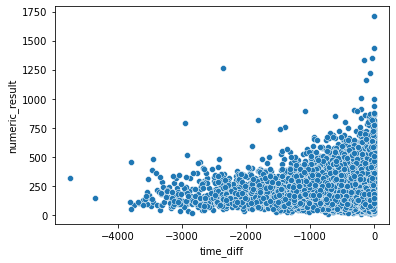

In [174]:
sns.scatterplot(data=df_glucose_final,x="time_diff", y="numeric_result")

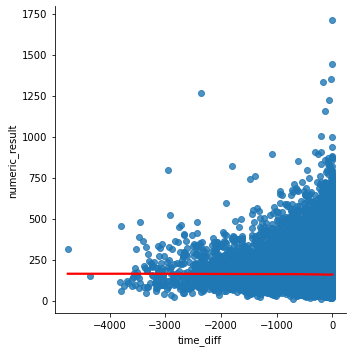

In [175]:
sns.lmplot(data=df_glucose_final,x="time_diff", y="numeric_result",lowess=True,line_kws={"color":"red"})

In [204]:
df_creat_final.to_csv('df_creat_final.csv')

In [184]:
patient_int=list(set(df_creat_final.patient_sk.unique())&set(df_HbA1C_final.patient_sk.unique())&set(df_wbc_final.patient_sk.unique())&set(df_glucose_final.patient_sk.unique()))

In [205]:
df_creat_final

,encounter_id,patient_sk,lab_procedure_name,unit,lab_verified_dt_tm,dr_encounter,race,gender,age_in_years,admitted_dt_tm,encounter_order,numeric_result,last_time,time_diff
0,327762424,40184,"Creatinine, Serum Quantitative",mg/dL,2014-04-15 21:07:00,0,Caucasian,Male,55.0,2014-04-15 23:07:00.0000000,1,2.540000,2014-12-19 10:19:00,-247
1,342969278,40184,"Creatinine, Serum Quantitative",mg/dL,2014-07-21 18:16:00,0,Caucasian,Male,55.0,2014-07-21 12:54:00.0000000,2,2.185000,2014-12-19 10:19:00,-150
2,355189214,40184,"Creatinine, Serum Quantitative",mg/dL,2014-12-10 22:58:00,0,Caucasian,Male,55.0,2014-11-27 07:59:00.0000000,3,2.430000,2014-12-19 10:19:00,-8
3,364897338,40184,"Creatinine, Serum Quantitative",mg/dL,2014-12-19 10:19:00,1,Caucasian,Male,55.0,2014-12-19 10:16:00.0000000,4,3.334615,2014-12-19 10:19:00,0
4,308345026,40603,"Creatinine, Serum Quantitative",mg/dL,2014-01-28 15:50:00,0,Unknown,Female,68.0,2014-01-28 08:26:00.0000000,1,2.290000,2014-03-26 16:40:00,-57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49199,445096412,104656321,"Creatinine, Serum Quantitative",mg/dL,2015-06-22 04:38:00,1,Caucasian,Male,48.0,2015-06-15 12:47:00.0000000,4,5.000000,2015-06-22 04:38:00,0
49200,444412882,104700366,"Creatinine, Serum Quantitative",mg/dL,2015-04-02 05:38:00,0,African American,Female,53.0,2015-03-30 01:10:00.0000000,1,3.290000,2015-06-22 03:37:00,-80
49201,444676159,104700366,"Creatinine, Serum Quantitative",mg/dL,2015-04-15 04:49:00,0,African American,Female,53.0,2015-04-08 19:26:00.0000000,2,2.270000,2015-06-22 03:37:00,-67
49202,444820403,104700366,"Creatinine, Serum Quantitative",mg/dL,2015-05-15 13:32:00,0,Caucasian,Female,53.0,2015-05-15 12:53:00.0000000,3,2.690000,2015-06-22 03:37:00,-37
